In [139]:
import geopandas, pandas, numpy
from string import ascii_lowercase as alc


da_2021 = "../Data/lda_000b21a_e/lda_000b21a_e.shp"
da_2006 = "../Data/gda_000b06a_e/gda_000b06a_e.shp"
csd_2021 = "../Data/lcsd000b21a_e/lcsd000b21a_e.shp"

canada_da_21 = geopandas.read_file(da_2021)
canada_da_06 = geopandas.read_file(da_2006)
canada_csd_21 = geopandas.read_file(csd_2021)

ontario_da_21 = canada_da_21[canada_da_21['PRUID'] == '35']
ontario_da_06 = canada_da_06[canada_da_06['PRUID'] == '35']
ontario_csd_21 = canada_csd_21[canada_csd_21['PRUID'] == '35']

region_summary = "../../../ggh-growth/regions-summary.csv"
region_summary = pandas.read_csv(region_summary)



Bridging the Gap Between CSDUID and DAUID


In [171]:
#import census reference table, which contains the DGUID for DA and CSD level. 
DA_to_CSD = "../Data/2021_DA_CSDUID_Reference_Table.csv"
DA_to_CSD = pandas.read_csv(DA_to_CSD)
#merge the reference table to the Ontario DA file for 2021
DA_with_CSDDGUID = pandas.merge(DA_to_CSD, ontario_da_21, right_on = "DGUID", left_on = "DADGUID_ADIDUGD", sort=False)
#copy the 'DGUID', 'CSDUID' to a new dataframe called DA_with_CSD, then merge it to DA_with_CSDDGUID
DA_with_CSD = ontario_csd_21[['DGUID', 'CSDUID']].copy()
GGH_DA_with_CSDUID_21 = pandas.merge(DA_with_CSD, DA_with_CSDDGUID,  right_on= "CSDDGUID_SDRIDUGD", left_on= "DGUID", sort=False)
#remove redundant fields 
GGH_DA_with_CSDUID_21 = GGH_DA_with_CSDUID_21.drop(["CSDDGUID_SDRIDUGD", "LANDAREA", "DADGUID_ADIDUGD", "DGUID_y","PRUID", "DGUID_x", "geometry"], axis = 1)
GGH_DA_with_CSDUID_06 = ontario_da_06.drop(["CDUID", "ERUID", "CCSUID", "CTUID", "CMAUID", "PRUID", "geometry"], axis = 1)
#canada_da_21.drop('CensusID2', axis =1)



In [172]:
#turn the region summary into a list
censusIDList = region_summary['CDUID2'].tolist()
municipalityList = region_summary['Municipality'].tolist()
macroList = region_summary["Macro"].tolist()
#loop through the list to add a new field called CSDID2, CSDID2 will be a new key for joining with regions-summary.csv
i = 0
while i < len(censusIDList):
    regionID = censusIDList[i]
    macro = macroList[i]
    municipality = municipalityList[i]
    GGH_DA_with_CSDUID_21.loc[GGH_DA_with_CSDUID_21['CSDUID'].str.startswith(f'{regionID}'), "Macro"] = macro
    GGH_DA_with_CSDUID_06.loc[GGH_DA_with_CSDUID_06['CSDUID'].str.startswith(f'{regionID}'), "Macro"] = macro
    GGH_DA_with_CSDUID_21.loc[GGH_DA_with_CSDUID_21['CSDUID'].str.startswith(f'{regionID}'), "Municipality"] = municipality
    GGH_DA_with_CSDUID_06.loc[GGH_DA_with_CSDUID_06['CSDUID'].str.startswith(f'{regionID}'), "Municipality"] = municipality
    i+=1

GGH_DA_with_CSDUID_21 = GGH_DA_with_CSDUID_21.dropna()
GGH_DA_with_CSDUID_06 = GGH_DA_with_CSDUID_06.dropna()

Joining Census Data With the Census Boundary Files

In [254]:
import geopandas, pandas, numpy
from string import ascii_lowercase as alc
census_ontario_data_06 = "../Data/Census Data/Census2006.csv"
census_ontario_data_06 = pandas.read_csv(census_ontario_data_06, encoding='utf-8')
census_ontario_data_21 = "../Data/Census Data/Census2021.csv"
census_ontario_data_21 = pandas.read_csv(census_ontario_data_21, encoding='utf-8')

In [255]:


GGH_DA_with_CSDUID_06["DAUID"] = GGH_DA_with_CSDUID_06["DAUID"].astype('str')
census_ontario_data_06["Dauid"] = census_ontario_data_06["Dauid"].astype('str')
GGH_Census_06 = pandas.merge(GGH_DA_with_CSDUID_06, census_ontario_data_06,  left_on= "DAUID", right_on= "Dauid", sort=False)

GGH_DA_with_CSDUID_21["DAUID"] = GGH_DA_with_CSDUID_21["DAUID"].astype('str')
census_ontario_data_21["GEO UID"] = census_ontario_data_21["GEO UID"].astype('str')
GGH_Census_21 = pandas.merge(GGH_DA_with_CSDUID_21, census_ontario_data_21,  left_on= "DAUID", right_on= "GEO UID", sort=False)
GGH_Census_06 = GGH_Census_06.drop('Dauid', axis =1)
GGH_Census_21 = GGH_Census_21.drop(['GEO UID', 'Land area in square kilometres'], axis = 1)

fields_06 = GGH_Census_06.columns [4:].tolist()
fields_21 = GGH_Census_21.columns [4:].tolist()
[]
i = 0
while i < len(fields_06):
    
    GGH_Census_06.rename(columns={f'{fields_06[i]}': f'{alc[i]}-{fields_06[i]}'}, inplace=True)
    GGH_Census_21.rename(columns={f'{fields_21[i]}': f'{alc[i]}-{fields_21[i]}'}, inplace=True)
    i+=1

GGH06_fields = GGH_Census_06.columns [4:].tolist()
GGH21_fields = GGH_Census_21.columns [4:].tolist()





In [256]:

GGH_Census_06.to_csv("../Export/GGH-Census-06.csv")
GGH_Census_21.to_csv("../Export/GGH-Census-21.csv")

In [258]:

pivot_table_06 = pandas.pivot_table(data = GGH_Census_06, values = GGH06_fields, index = ['Municipality'], aggfunc = numpy.sum)
pivot_table_21 = pandas.pivot_table(data = GGH_Census_21, values = GGH21_fields, index = ['Municipality'], aggfunc = numpy.sum)
pivot_table_06 = pivot_table_06.reset_index()
pivot_table_21 = pivot_table_21.reset_index()

pivotField_06 = pivot_table_06.columns.tolist()
pivotField_21 = pivot_table_21.columns.tolist()
i = 1
while i < len(pivotField_06):
    
    pivot_table_06.rename(columns={f'{pivotField_06[i]}': f'2006-{pivotField_06[i]}'}, inplace=True)
    pivot_table_21.rename(columns={f'{pivotField_21[i]}': f'2021-{pivotField_21[i]}'}, inplace=True)
    i+=1

pivot_table = pandas.merge(pivot_table_06, pivot_table_21 , on = "Municipality", sort=False)


In [259]:
pivot_table

,Municipality,2006-a-Population,2006-b-Total number of occupied private dwellings,2006-c-Total dwellings structures,2006-d-Single-detached house,2006-e-Semi-detached house,2006-f-Row house,"2006-g-Apartment, duplex","2006-h-Apartment, building that has five or more storeys","2006-i-Apartment, building that has fewer than five storeys",2006-j-Other single-attached house,2006-k-Movable dwelling,2006-l-Total households,2021-a-Population,2021-b-Total private dwellings,2021-c-Total dwelling type,2021-d-Single-detached house,2021-e-Semi-detached house,2021-f-Row house,2021-g-Apartment or flat in a duplex,2021-h-Apartment in a building that has five or more storeys,2021-i-Apartment in a building that has fewer than five storeys,2021-j-Other single-attached house,2021-k-Movable dwelling,2021-l-Total households
0,City of Barrie,127773.0,46065.0,46195.0,28870.0,2125.0,4615.0,2475.0,3330.0,4625.0,5.0,135.0,46205.0,147829.0,57276.0,55400.0,32160.0,2305.0,6345.0,3710.0,4250.0,6375.0,20.0,20.0,55285.0
1,City of Brantford,90192.0,35475.0,35615.0,21810.0,1920.0,2955.0,1400.0,3715.0,3685.0,100.0,10.0,35585.0,104688.0,43269.0,41675.0,25290.0,1940.0,3950.0,1585.0,4470.0,4350.0,40.0,10.0,41670.0
2,City of Guelph,114943.0,44370.0,44720.0,23950.0,1885.0,5205.0,2725.0,5060.0,5745.0,30.0,15.0,44710.0,143740.0,59746.0,56480.0,27450.0,2470.0,8605.0,3595.0,6515.0,7690.0,30.0,0.0,56515.0
3,City of Hamilton,502897.0,193405.0,193960.0,111780.0,5970.0,18610.0,6805.0,32715.0,17295.0,485.0,270.0,193960.0,569353.0,233564.0,222710.0,125105.0,6685.0,27465.0,7285.0,36415.0,18925.0,315.0,130.0,222765.0
4,City of Kawartha Lakes,74561.0,29395.0,29525.0,24720.0,565.0,450.0,630.0,630.0,2275.0,155.0,140.0,29480.0,79247.0,38947.0,32675.0,27410.0,545.0,640.0,815.0,730.0,2210.0,75.0,240.0,32715.0
5,City of Orillia,29945.0,12165.0,12225.0,7165.0,305.0,815.0,760.0,720.0,2270.0,30.0,165.0,12250.0,33411.0,15428.0,14390.0,8005.0,350.0,1225.0,920.0,915.0,2760.0,30.0,160.0,14410.0
6,City of Peterborough,74898.0,31140.0,31200.0,18300.0,785.0,2175.0,2160.0,2545.0,5165.0,40.0,0.0,31185.0,83651.0,38006.0,36020.0,20550.0,785.0,3015.0,2585.0,2580.0,6360.0,20.0,0.0,35980.0
7,City of Toronto,2492763.0,969620.0,975645.0,266790.0,69470.0,54535.0,43985.0,377035.0,162165.0,1350.0,220.0,975815.0,2794356.0,1253238.0,1160845.0,270405.0,71835.0,62755.0,47725.0,542200.0,161875.0,2515.0,30.0,1160795.0
8,County of Brant,34415.0,12220.0,12270.0,10365.0,815.0,380.0,160.0,50.0,455.0,50.0,5.0,12255.0,39474.0,14778.0,14355.0,11590.0,960.0,760.0,185.0,75.0,665.0,25.0,55.0,14360.0
9,County of Dufferin,54436.0,18705.0,18800.0,13940.0,1340.0,1070.0,315.0,575.0,1385.0,55.0,55.0,18775.0,66257.0,24388.0,23315.0,17720.0,1450.0,1520.0,280.0,565.0,1725.0,30.0,10.0,23320.0


In [260]:

pivot_field = pivot_table.columns.tolist()
i = 1

while i <= (len(pivot_field)-1)/2:
    changeField = pivot_field[i].replace("2006", "")

    print(changeField)
    pivot_table[f'chg{changeField}'] = pivot_table [pivot_field[i+12]]  - pivot_table [pivot_field[i]]
    print(f'chg_{changeField}')
    i+=1



pivot_table.to_csv("../Export/GGH-Census-Change.csv")


-a-Population
chg_-a-Population
-b-Total number of occupied private dwellings
chg_-b-Total number of occupied private dwellings
-c-Total dwellings structures
chg_-c-Total dwellings structures
-d-Single-detached house
chg_-d-Single-detached house
-e-Semi-detached house
chg_-e-Semi-detached house
-f-Row house
chg_-f-Row house
-g-Apartment, duplex
chg_-g-Apartment, duplex
-h-Apartment, building that has five or more storeys
chg_-h-Apartment, building that has five or more storeys
-i-Apartment, building that has fewer than five storeys
chg_-i-Apartment, building that has fewer than five storeys
-j-Other single-attached house
chg_-j-Other single-attached house
-k-Movable dwelling
chg_-k-Movable dwelling
-l-Total households
chg_-l-Total households


In [261]:
pandas.set_option('display.max_columns', None)
pivot_table.columns.tolist()


['Municipality',
 '2006-a-Population',
 '2006-b-Total number of occupied private dwellings',
 '2006-c-Total dwellings structures',
 '2006-d-Single-detached house',
 '2006-e-Semi-detached house',
 '2006-f-Row house',
 '2006-g-Apartment, duplex',
 '2006-h-Apartment, building that has five or more storeys',
 '2006-i-Apartment, building that has fewer than five storeys',
 '2006-j-Other single-attached house',
 '2006-k-Movable dwelling',
 '2006-l-Total households',
 '2021-a-Population',
 '2021-b-Total private dwellings',
 '2021-c-Total dwelling type',
 '2021-d-Single-detached house',
 '2021-e-Semi-detached house',
 '2021-f-Row house',
 '2021-g-Apartment or flat in a duplex',
 '2021-h-Apartment in a building that has five or more storeys',
 '2021-i-Apartment in a building that has fewer than five storeys',
 '2021-j-Other single-attached house',
 '2021-k-Movable dwelling',
 '2021-l-Total households',
 'chg-a-Population',
 'chg-b-Total number of occupied private dwellings',
 'chg-c-Total dwell

In [245]:

ggh_regions = geopandas.read_file("../../../ggh-growth/ggh-growth-plan-regions.geojson")
ggh1 = pandas.merge(ggh_regions, pivot_table, right_on = "Municipality", left_on = "Name", sort=False).drop(['Name'], axis = 1)
ggh1.explore(column = 'chg-h-Apartment, building that has five or more storeys', legend = True, cmap = "Purples", scheme="quantiles")

KeyError: 'chg-h-Apartment, building that has five or more storeys'

AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

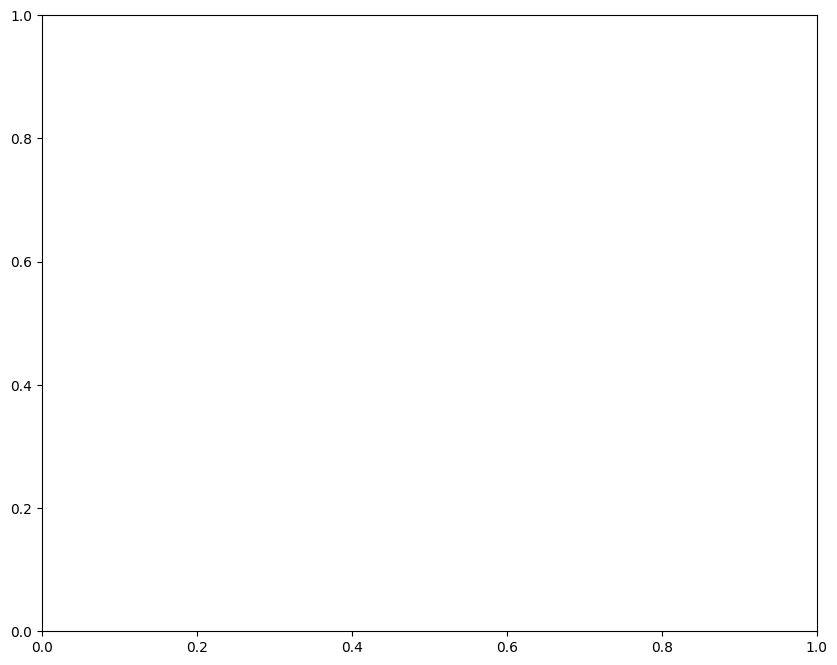

In [222]:
for field in GGH_Census_21.columns.tolist()[5:]:
    maps = GGH_Census_21.plot(column = field, legend = True, cmap='Purples', edgecolor="grey", linewidth = 0.01, scheme='quantiles', figsize = (10.0,8.0), aspect = "auto", legend_kwds={'bbox_to_anchor': (1.3, 1)})
    maps.set_axis_off()
    maps.set_title(field)

    output_file_name = f"../Export/Maps/2021_{field}.png"
    maps.get_figure().savefig(output_file_name, dpi = 600)


KeyboardInterrupt



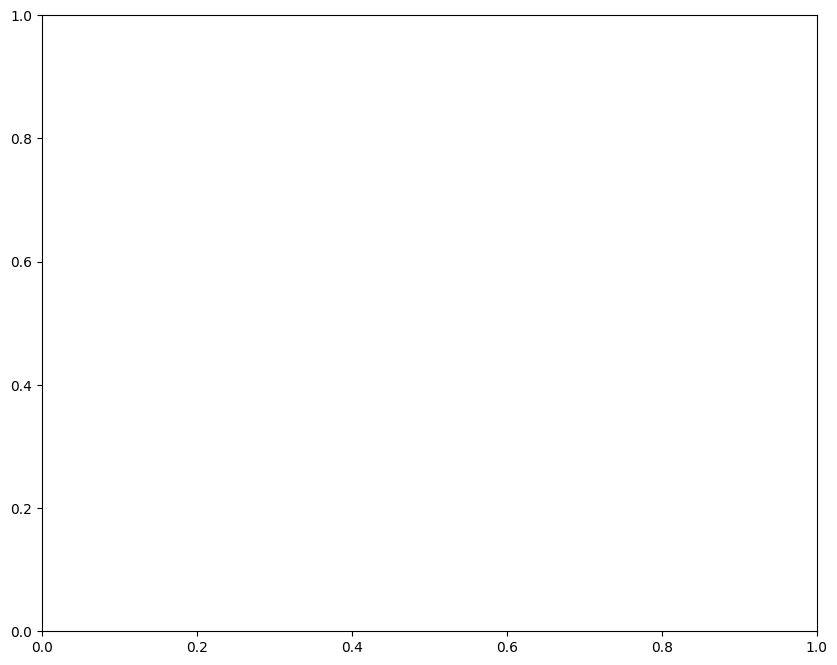

In [ ]:
for field in GGH_Census_06.columns.tolist()[5:]:
    maps = GGH_Census_06.plot(column = field, legend = True, cmap='Purples', edgecolor="grey", linewidth = 0.01, scheme='quantiles', figsize = (10.0,8.0), aspect = "auto", legend_kwds={'bbox_to_anchor': (1.3, 1)})
    maps.set_axis_off()
    maps.set_title(field)

    output_file_name = f"../Export/Maps/2006_{field}.png"
    maps.get_figure().savefig(output_file_name, dpi = 600)

In [ ]:
for field in ggh.columns.tolist()[3:]:
    maps = ggh.plot(column = field, legend = True, cmap='Purples', edgecolor="grey", linewidth = 0.4, scheme='quantiles', figsize = (10.0,8.0), aspect = "auto", legend_kwds={'bbox_to_anchor': (1.3, 1)})
    maps.set_axis_off()
    maps.set_title(field)

    output_file_name = f"../Export/Maps/Change_{field}.png"
    maps.get_figure().savefig(output_file_name, dpi = 600)
